<a href="https://colab.research.google.com/github/anime19/image-colorization/blob/master/image_colorization_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paths

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%cd /content/drive/My Drive/Image-Colorization

/content/drive/My Drive/Image-Colorization


In [0]:
data_path = "/content/drive/My Drive/Colab Notebooks/coco256resize"
model_checkpoint_path = "./output/model/model_checkpoint.hdf5"
model_summary_path = "./output/model/model_summary.svg"
config_path = "./config"

# Configurations

In [0]:
img_dim = 256
nb_neighbors = 5
batch_size = 2
kernel = 3
channel = 3
epochs = 50
patience = 50
num_classes = 313
kernel = 3
weight_decay = 1e-3
epsilon = 1e-8
lr = 1e-5
# temperature parameter T
T = 0.38

# Imports

In [0]:
import os
import numpy as np
import glob
from random import randint, shuffle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io, color
import cv2 as cv
import keras.backend as K
import tensorflow as tf
from keras.layers import Input, Conv2D, BatchNormalization, UpSampling2D
from keras.models import Model
from keras.regularizers import l2
from keras.utils import plot_model
import sklearn.neighbors as nn
from keras.callbacks import ModelCheckpoint
import keras
import random


# utils


## show img by path/img

In [0]:
def show_img_path(path):
    img=mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.show()

In [0]:
def show_img(img):
    imgplot = plt.imshow(img)
    plt.show()

## RGB to LAB

In [0]:
def rgb_to_lab(img):
    return  cv.cvtColor(img, cv.COLOR_BGR2LAB)
#     return color.rgb2lab(img)

## soft encoding

In [0]:
def get_soft_encoding(image_ab, nn_finder, nb_q):
    h, w = image_ab.shape[:2]
    a = np.ravel(image_ab[:, :, 0])
    b = np.ravel(image_ab[:, :, 1])
    ab = np.vstack((a, b)).T
    # Get the distance to and the idx of the nearest neighbors
    dist_neighb, idx_neigh = nn_finder.kneighbors(ab)
    # Smooth the weights with a gaussian kernel
    sigma_neighbor = 5
    wts = np.exp(-dist_neighb ** 2 / (2 * sigma_neighbor ** 2))
    wts = wts / np.sum(wts, axis=1)[:, np.newaxis]
    # format the tar get
    y = np.zeros((ab.shape[0], nb_q))
    idx_pts = np.arange(ab.shape[0])[:, np.newaxis]
    y[idx_pts, idx_neigh] = wts
    y = y.reshape(h, w, nb_q)
    return y

# Loading data

In [0]:
list_imgs = glob.glob(data_path + "/*")
data_size = len(list_imgs)
print("Data size = " + str(data_size))
# suffle dataset
shuffle(list_imgs)


Data size = 10000


## Preview sample data

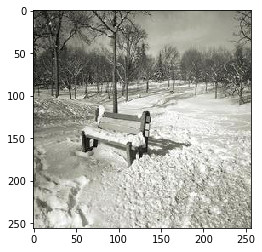

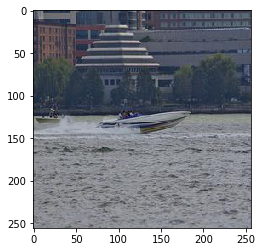

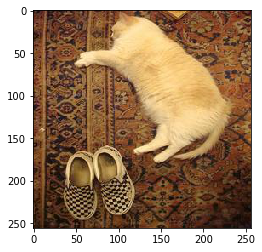

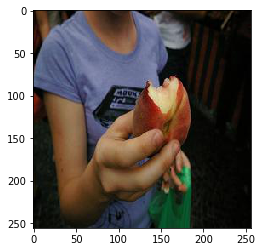

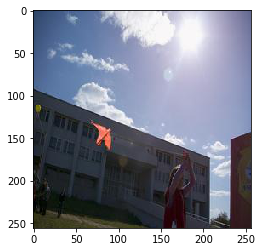

In [0]:
num_to_sample = 5
for i in range(num_to_sample):
    try:
        index = randint(0, data_size-1)
        img = list_imgs[index]
        show_img_path(img)
    except:
        pass
        

## Find color distribution in dataset

## find size distribution in dataset

# Split data


In [0]:
split_val = 0.2

split_num = int(data_size*split_val)
x_img_val = list_imgs[0:100]
x_img_train = list_imgs[100:2100]
x_img_test = list_imgs[2101:2201]

train_len = len(x_img_train)
test_len = len(x_img_val)
print(len(x_img_test))


print("Training on {} example and validating on {} example"
      .format(train_len, test_len))

100
Training on 2000 example and validating on 100 example


# Generate batch

In [0]:
q_ab = np.load(config_path + "/pts_in_hull.npy")
nb_q = q_ab.shape[0]
# Fit a NN to q_ab
nn_finder = nn.NearestNeighbors(n_neighbors=nb_neighbors, algorithm='ball_tree').fit(q_ab)
def get_batch(full_list, batch_size=batch_size):
    while True:
        i_batch = 0
        x = np.empty((batch_size, img_dim, img_dim, 1), dtype=np.float32)
        y = np.empty((batch_size, img_dim//4, img_dim//4, nb_q), dtype=np.float32)
        while i_batch < batch_size:
            try:
                img_index =  random.randint(0,data_size)
                img = list_imgs[img_index]
                l, ab_enc = get_x_y(img)
                x[i_batch, :, :, 0] = l
                y[i_batch] = ab_enc
                i_batch = i_batch + 1 
            except Exception as e:
                pass
        yield x, y




In [0]:
def get_x_y(img_path):
    rgb = cv.imread(img_path)
    lab_img = rgb_to_lab(rgb)
    out_lab = cv.resize(lab_img, (img_dim//4, img_dim//4), cv.INTER_CUBIC)
    out_ab = out_lab[:, :, 1:].astype(np.int32) - 128
    ab_enc = get_soft_encoding(out_ab, nn_finder, nb_q)
    l = cv.imread(img_path, 0)/255.
    l = cv.resize(l, (img_dim, img_dim), cv.INTER_CUBIC)
    return l, ab_enc
    

# MODEL

## Build model

In [0]:
def build_model():
    l2_reg = l2(1e-3)
    input_tensor = Input(shape=(img_dim, img_dim, 1))
    x = Conv2D(64, (kernel, kernel), activation='relu', padding='same', name='conv1_1', kernel_initializer="he_normal",
               kernel_regularizer=l2_reg)(input_tensor)
    x = Conv2D(64, (kernel, kernel), activation='relu', padding='same', name='conv1_2', kernel_initializer="he_normal",
               kernel_regularizer=l2_reg, strides=(2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, (kernel, kernel), activation='relu', padding='same', name='conv2_1', kernel_initializer="he_normal",
               kernel_regularizer=l2_reg)(x)
    x = Conv2D(128, (kernel, kernel), activation='relu', padding='same', name='conv2_2', kernel_initializer="he_normal",
               kernel_regularizer=l2_reg,
               strides=(2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='conv3_1',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='conv3_2',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='conv3_3', kernel_initializer="he_normal",
               strides=(2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', name='conv4_1',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', name='conv4_2',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', name='conv4_3',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)

    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', dilation_rate=2, name='conv5_1',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', dilation_rate=2, name='conv5_2',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', dilation_rate=2, name='conv5_3',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)

    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', dilation_rate=2, name='conv6_1',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', dilation_rate=2, name='conv6_2',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', dilation_rate=2, name='conv6_3',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)

    x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='conv7_1',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='conv7_2',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='conv7_3',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (kernel, kernel), activation='relu', padding='same', name='conv8_1',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(128, (kernel, kernel), activation='relu', padding='same', name='conv8_2',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(128, (kernel, kernel), activation='relu', padding='same', name='conv8_3',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax', padding='same', name='pred')(x)

    model = Model(inputs=input_tensor, outputs=outputs, name="ColorNet")
    return model


## Model details


In [0]:
model = build_model()
print(model.summary())
plot_model(model, to_file=model_summary_path, show_layer_names=True, show_shapes=True)
















Model: "ColorNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 256, 256, 64)      640       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
conv2_1 (Conv2D)             (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 64, 64, 128)       147584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 1

ValueError: ignored

## Loss function

In [0]:
# Load the color prior factor that encourages rare colors
prior_factor = np.load( config_path + "/prior_factor.npy")
prior_factor = prior_factor.astype(np.float32)
def categorical_crossentropy_color(y_true, y_pred):
    q = 313
    y_true = K.reshape(y_true, (-1, q))
    y_pred = K.reshape(y_pred, (-1, q))

    idx_max = K.argmax(y_true, axis=1)
    weights = K.gather(prior_factor, idx_max)
    weights = K.reshape(weights, (-1, 1))

    # multiply y_true by weights
    y_true = y_true * weights

    cross_ent = K.categorical_crossentropy(y_pred, y_true)
    cross_ent = K.mean(cross_ent, axis=-1)

    return cross_ent

## Train model

In [0]:
model_checkpoint = ModelCheckpoint(model_checkpoint_path, monitor='val_loss',
                                   verbose=1, save_best_only=True)
callbacks = [model_checkpoint]
adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.99, epsilon=epsilon)
model.compile(optimizer=adam, loss=categorical_crossentropy_color, metrics=['accuracy'])


In [0]:
history  = model.fit_generator(get_batch(x_img_train),
#                             steps_per_epoch=len(x_img_train) // batch_size,
                            steps_per_epoch=10,
                            validation_data=(get_batch(x_img_val)),
#                             validation_steps=len(x_img_val) // batch_size,
                            validation_steps=10,
                            epochs=epochs,
                            verbose=1,
                            )



Epoch 1/50
10/10 [==============================] - 129s 13s/step - loss: 29.1996 - acc: 0.0037 - val_loss: 29.1938 - val_acc: 0.0036
Epoch 2/50
10/10 [==============================] - 121s 12s/step - loss: 29.1786 - acc: 0.0046 - val_loss: 29.1108 - val_acc: 0.0071
Epoch 3/50
10/10 [==============================] - 122s 12s/step - loss: 29.1459 - acc: 0.0077 - val_loss: 28.4484 - val_acc: 0.0222
Epoch 4/50
10/10 [==============================] - 122s 12s/step - loss: 29.0325 - acc: 0.0177 - val_loss: 27.2732 - val_acc: 0.0487
Epoch 5/50
10/10 [==============================] - 121s 12s/step - loss: 28.8241 - acc: 0.0291 - val_loss: 26.3776 - val_acc: 0.0541
Epoch 6/50
10/10 [==============================] - 122s 12s/step - loss: 28.5264 - acc: 0.0290 - val_loss: 25.2247 - val_acc: 0.0696
Epoch 7/50
10/10 [==============================] - 121s 12s/step - loss: 28.1165 - acc: 0.0573 - val_loss: 26.8199 - val_acc: 0.0479
Epoch 8/50
10/10 [==============================] - 122s 12s

## History

In [0]:
#model.save('a.h5')
model.save('b.h5')

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


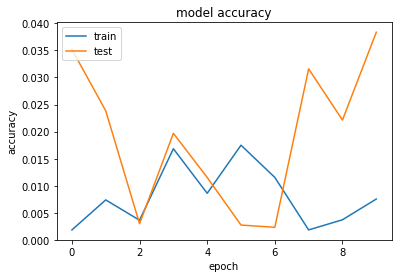

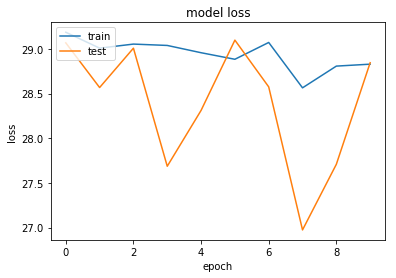

In [0]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
from keras.models import Model,load_model
model=load_model('a.h5')

ValueError: ignored

# Predictions

In [0]:
def predict(filename):
    h, w = img_dim // 4, img_dim // 4
    img_rows = img_dim
    img_cols = img_dim
    bgr = cv.imread(filename)
    gray = cv.imread(filename, 0)
    bgr = cv.resize(bgr, (img_rows, img_cols), cv.INTER_CUBIC)
    gray = cv.resize(gray, (img_rows, img_cols), cv.INTER_CUBIC)
    # L: 0 <=L<= 255, a: 42 <=a<= 226, b: 20 <=b<= 223.
    lab = cv.cvtColor(bgr, cv.COLOR_BGR2LAB)
    L = lab[:, :, 0]
    a = lab[:, :, 1]
    b = lab[:, :, 2]
    # print('np.max(L): ' + str(np.max(L)))
    # print('np.min(L): ' + str(np.min(L)))
    # print('np.max(a): ' + str(np.max(a)))
    # print('np.min(a): ' + str(np.min(a)))
    # print('np.max(b): ' + str(np.max(b)))
    # print('np.min(b): ' + str(np.min(b)))
    x_test = np.empty((1, img_rows, img_cols, 1), dtype=np.float32)
    x_test[0, :, :, 0] = gray / 255.

    # L: 0 <=L<= 255, a: 42 <=a<= 226, b: 20 <=b<= 223.
    X_colorized = model.predict(x_test)
    X_colorized = X_colorized.reshape((h * w, nb_q))

    # Reweight probas
    X_colorized = np.exp(np.log(X_colorized + epsilon) / T)
    X_colorized = X_colorized / np.sum(X_colorized, 1)[:, np.newaxis]

    # Reweighted
    q_a = q_ab[:, 0].reshape((1, 313))
    q_b = q_ab[:, 1].reshape((1, 313))

    X_a = np.sum(X_colorized * q_a, 1).reshape((h, w))
    X_b = np.sum(X_colorized * q_b, 1).reshape((h, w))
    # print('np.max(X_a): ' + str(np.max(X_a)))
    # print('np.min(X_a): ' + str(np.min(X_a)))
    # print('np.max(X_b): ' + str(np.max(X_b)))
    # print('np.min(X_b): ' + str(np.min(X_b)))
    X_a = cv.resize(X_a, (img_rows, img_cols), cv.INTER_CUBIC)
    X_b = cv.resize(X_b, (img_rows, img_cols), cv.INTER_CUBIC)

    # Before: -90 <=a<= 100, -110 <=b<= 110
    # After: 38 <=a<= 228, 18 <=b<= 238
    X_a = X_a + 128
    X_b = X_b + 128
    # print('np.max(X_a): ' + str(np.max(X_a)))
    # print('np.min(X_a): ' + str(np.min(X_a)))
    # print('np.max(X_b): ' + str(np.max(X_b)))
    # print('np.min(X_b): ' + str(np.min(X_b)))

    out_lab = np.zeros((img_rows, img_cols, 3), dtype=np.int32)
    out_lab[:, :, 0] = lab[:, :, 0]
    out_lab[:, :, 1] = X_a
    out_lab[:, :, 2] = X_b
    out_L = out_lab[:, :, 0]
    out_a = out_lab[:, :, 1]
    out_b = out_lab[:, :, 2]
    # print('np.max(out_L): ' + str(np.max(out_L)))
    # print('np.min(out_L): ' + str(np.min(out_L)))
    # print('np.max(out_a): ' + str(np.max(out_a)))
    # print('np.min(out_a): ' + str(np.min(out_a)))
    # print('np.max(out_b): ' + str(np.max(out_b)))
    # print('np.min(out_b): ' + str(np.min(out_b)))
    out_lab = out_lab.astype(np.uint8)
    out_bgr = cv.cvtColor(out_lab, cv.COLOR_LAB2BGR)
    # print('np.max(out_bgr): ' + str(np.max(out_bgr)))
    # print('np.min(out_bgr): ' + str(np.min(out_bgr)))
    out_bgr = out_bgr.astype(np.uint8)
    
    print("original")
    show_img_path(filename)
    
    print("grey:")
    show_img(gray)
    
    print("bgr:")
    show_img(bgr)

    print("out:")
    show_img(out_bgr)
    


In [0]:
for i in range (100):
                                                                              
  predict(x_img_test[i])

In [0]:
for i in range (102):

  predict(x_img_test[i])